In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Loading CSV into pandas dataframe for data cleaning

In [93]:
suicides = pd.read_csv('suicides.csv')

#### Initial look at the data for data cleaning

In [94]:
suicides.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,FactValueUoM,FactValueNumericLowPrefix,FactValueNumericLow,FactValueNumericHighPrefix,FactValueNumericHigh,Value,FactValueTranslationID,FactComments,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,EN,2021-07-06T04:00:00.000Z


#### Remove metadata columns and missing data to create a usable dataset for EDA

In [95]:
# Check columns to identify which columns to drop that contain missing data over 60%
suicides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   IndicatorCode               4392 non-null   object 
 1   Indicator                   4392 non-null   object 
 2   ValueType                   4392 non-null   object 
 3   ParentLocationCode          4392 non-null   object 
 4   ParentLocation              4392 non-null   object 
 5   Location type               4392 non-null   object 
 6   SpatialDimValueCode         4392 non-null   object 
 7   Location                    4392 non-null   object 
 8   Period type                 4392 non-null   object 
 9   Period                      4392 non-null   int64  
 10  IsLatestYear                4392 non-null   bool   
 11  Dim1 type                   4392 non-null   object 
 12  Dim1                        4392 non-null   object 
 13  Dim1ValueCode               4392 

In [96]:
# Drop missing data columns to clean the dataset
suicides.dropna(axis='columns', how='all', inplace=True)
suicides.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,FactValueNumeric,Value,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,15-24 years,YEARS15-24,0.0,0.0,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,25-34 years of age,YEARS25-34,0.0,0.0,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,35-44 years of age,YEARS35-44,0.0,0.0,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,45-54 years,YEARS45-54,0.0,0.0,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,65-74 years,YEARS65-74,0.0,0.0,EN,2021-07-06T04:00:00.000Z


In [97]:
#Check values of Dim2ValueCode to determine how to split the strings
suicides.Dim2ValueCode.value_counts()

YEARS15-24     549
YEARS25-34     549
YEARS35-44     549
YEARS45-54     549
YEARS65-74     549
YEARS75-84     549
YEARS85PLUS    549
YEARS55-64     549
Name: Dim2ValueCode, dtype: int64

In [98]:
#Replace YEARS with "" to prep for a column split
suicides['Dim2ValueCode'] = suicides['Dim2ValueCode'].replace('YEARS', '', regex=True)
print(suicides['Dim2ValueCode'].head())

#Split Dim2ValueCode (Age) into 2 columns age min/max for EDA and queries
suicides['AgeMin'] = suicides['Dim2ValueCode'].str.split('-', expand=True)[0]
suicides['AgeMax'] = suicides['Dim2ValueCode'].str.split('-', expand=True)[1]

#Check dataframe for accurate split and new columns
suicides.head()

0    15-24
1    25-34
2    35-44
3    45-54
4    65-74
Name: Dim2ValueCode, dtype: object


,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,FactValueNumeric,Value,Language,DateModified,AgeMin,AgeMax
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,BTSX,Age Group,15-24 years,15-24,0.0,0.0,EN,2021-07-06T04:00:00.000Z,15,24
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,BTSX,Age Group,25-34 years of age,25-34,0.0,0.0,EN,2021-07-06T04:00:00.000Z,25,34
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,BTSX,Age Group,35-44 years of age,35-44,0.0,0.0,EN,2021-07-06T04:00:00.000Z,35,44
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,BTSX,Age Group,45-54 years,45-54,0.0,0.0,EN,2021-07-06T04:00:00.000Z,45,54
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,BTSX,Age Group,65-74 years,65-74,0.0,0.0,EN,2021-07-06T04:00:00.000Z,65,74


In [99]:
# Identify columns to remove to create a clean dataset for EDA
suicide_columns = suicides.columns.to_list()
print(suicide_columns)

#Add desired columns to a list
desired_columns = ['ParentLocation', 'Location', 'Period', 'Value', 'Dim1', 'AgeMin', 'AgeMax']

['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode', 'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location', 'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1', 'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'FactValueNumeric', 'Value', 'Language', 'DateModified', 'AgeMin', 'AgeMax']


### Chosing columns for EDA (Metadata)

-- Metadata on columns for Crude Suicide Rates (per 100 000 population)-- <br>
ParentLocation = Region ('Americas', 'Western Pacific', 'Europe', 'Africa', 'South-East Asia', 'Eastern Mediterranean') <br>
Location = Country data surveyed (Multitude) <br>
Period = Year data collected <br>
Value = Crude Suicide Rates (per 100 000 population) <br>
Sex = Gender (Male/Female/Both) <br>
AgeMin / AgeMax = Age ranges for data (Assume 100 yrs old is max)

In [100]:
suicides_clean = suicides[desired_columns].rename(columns={'Dim1': 'Sex'})
suicides_clean.head()

,ParentLocation,Location,Period,Value,Sex,AgeMin,AgeMax
0,Americas,Antigua and Barbuda,2019,0.0,Both sexes,15,24
1,Americas,Antigua and Barbuda,2019,0.0,Both sexes,25,34
2,Americas,Antigua and Barbuda,2019,0.0,Both sexes,35,44
3,Americas,Antigua and Barbuda,2019,0.0,Both sexes,45,54
4,Americas,Antigua and Barbuda,2019,0.0,Both sexes,65,74


In [101]:
# Adjust Sex column where Both sexes = Both for simplicity
suicides_clean['Sex'] = suicides_clean.Sex.apply(lambda sex: 'Both' if sex == 'Both sexes' else sex)

# Check for correct changes
suicides_clean.Sex.value_counts()

Both      1464
Female    1464
Male      1464
Name: Sex, dtype: int64

### Check/adjust data types to complete data cleaning

In [102]:
suicides_clean.dtypes

ParentLocation     object
Location           object
Period              int64
Value             float64
Sex                object
AgeMin             object
AgeMax             object
dtype: object

#### Convert AgeMin/Max to int datatype for EDA

In [103]:
#Check values of both AgeMin/Max columns to see to check for strings to remove
suicides_clean.AgeMin.value_counts()
suicides_clean[suicides_clean.AgeMin == '85PLUS'].head()

,ParentLocation,Location,Period,Value,Sex,AgeMin,AgeMax
6,Americas,Antigua and Barbuda,2019,0.0,Both,85PLUS,None
13,Americas,Antigua and Barbuda,2019,0.0,Female,85PLUS,None
21,Americas,Antigua and Barbuda,2019,0.0,Male,85PLUS,None
26,Americas,Barbados,2019,0.0,Both,85PLUS,None
33,Americas,Barbados,2019,0.0,Female,85PLUS,None


In [104]:
#Convert strings to int to prep for dtype change
suicides_clean['AgeMin'] = suicides_clean.AgeMin.apply(lambda age: 85 if age == '85PLUS' else age)

#Check for correct changes
suicides_clean.AgeMin.value_counts()

15    549
25    549
35    549
45    549
65    549
75    549
85    549
55    549
Name: AgeMin, dtype: int64

In [105]:
#Check for values of AgeMax to clean
suicides_clean.AgeMax.unique()

array(['24', '34', '44', '54', '74', '84', None, '64'], dtype=object)

In [106]:
suicides_clean.isnull().sum()

ParentLocation      0
Location            0
Period              0
Value               0
Sex                 0
AgeMin              0
AgeMax            549
dtype: int64

In [107]:
#Fill na to prep for conversion to int dtype
#Assume 100 is the max
suicides_clean.fillna(value={'AgeMax': 100}, inplace=True)

#Check for correct changes
suicides_clean.AgeMax.unique()

array(['24', '34', '44', '54', '74', '84', 100, '64'], dtype=object)

In [108]:
#Convert to int dtype for EDA and to complete data cleaning
suicides_clean['AgeMin'] = pd.to_numeric(suicides_clean.AgeMin)
suicides_clean['AgeMax'] = pd.to_numeric(suicides_clean.AgeMax)

#Check for correct changes to complete data cleaning
suicides_clean.dtypes

ParentLocation     object
Location           object
Period              int64
Value             float64
Sex                object
AgeMin              int64
AgeMax              int64
dtype: object

### Univariate Data Profiling

Initial summary statistics to get a general picture of the data. <br>
Also to generate questions to answer using the data and potential model building

In [109]:
suicides_clean.describe()

,Period,Value,AgeMin,AgeMax
count,4392.0,4392.000000,4392.000000,4392.000000
mean,2019.0,23.242739,50.000000,59.750000
std,0.0,43.466528,22.915487,24.115761
min,2019.0,0.000000,15.000000,24.000000
25%,2019.0,4.890000,32.500000,41.500000
50%,2019.0,10.735000,50.000000,59.000000
75%,2019.0,23.577500,67.500000,76.500000
max,2019.0,646.000000,85.000000,100.000000


##### Mean suicide rates for by region

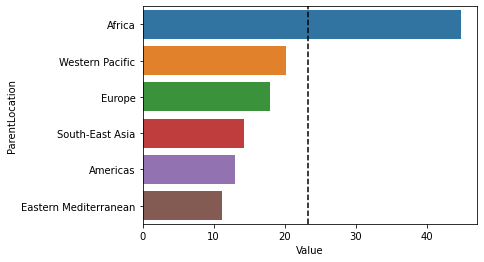

In [110]:
# Mean suicides rates including all regions to serve as a reference point in the bar graph 
suicide_rates_mean = suicides_clean.Value.mean()

# Sort values for each region in desending order for ordered barplot
suicides_means_sorted = suicides_clean.groupby(by='ParentLocation', as_index=False).Value.mean().sort_values(by='Value', ascending=False)

# Visualization of the means to identify trends
sns.barplot(data=suicides_means_sorted, y='ParentLocation', x='Value')
plt.axvline(suicide_rates_mean, linestyle='--', color='black')

Africa mean suicide rates exceed all other regions and the total average by nearly double or more<br>

##### Median suicide rates for by region

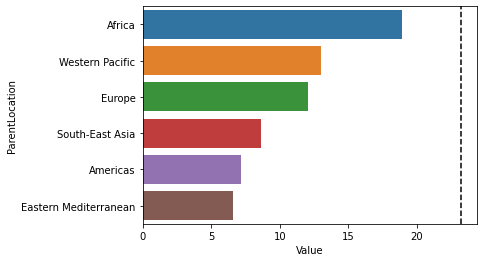

In [111]:
# Median suicides rates including all regions to serve as a reference point in the bar graph 
suicide_rates_median = suicides_clean.Value.median()

# Sort values for each region in desending order for ordered barplot
suicides_median_sorted = suicides_clean.groupby(by='ParentLocation', as_index=False).Value.median().sort_values(by='Value', ascending=False)

# Visualization of the medians to identify trends
sns.barplot(data=suicides_median_sorted, y='ParentLocation', x='Value')
plt.axvline(suicide_rates_mean, linestyle='--', color='black')

Africa median suicide rates exceeds all other regions but not to the extent of the mean suicide rates<br>
Median is more resistant summary statistic to outliers which can explain the differences<br>
The presence of outliers will have to be explored with histograms/boxplots

<AxesSubplot:xlabel='Value', ylabel='Count'>

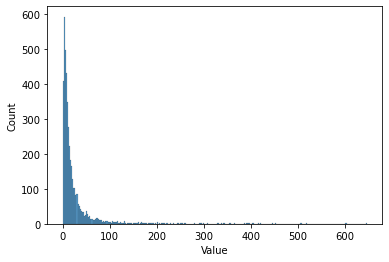

In [112]:
#Histogram to visualize the spread of the suicide rates of all countries together
sns.histplot(data=suicides_clean, x='Value')

Coarse search reveals right skewed spread due to outliers (All countries) <br>

#### Are the suicide rates skewed for each region?

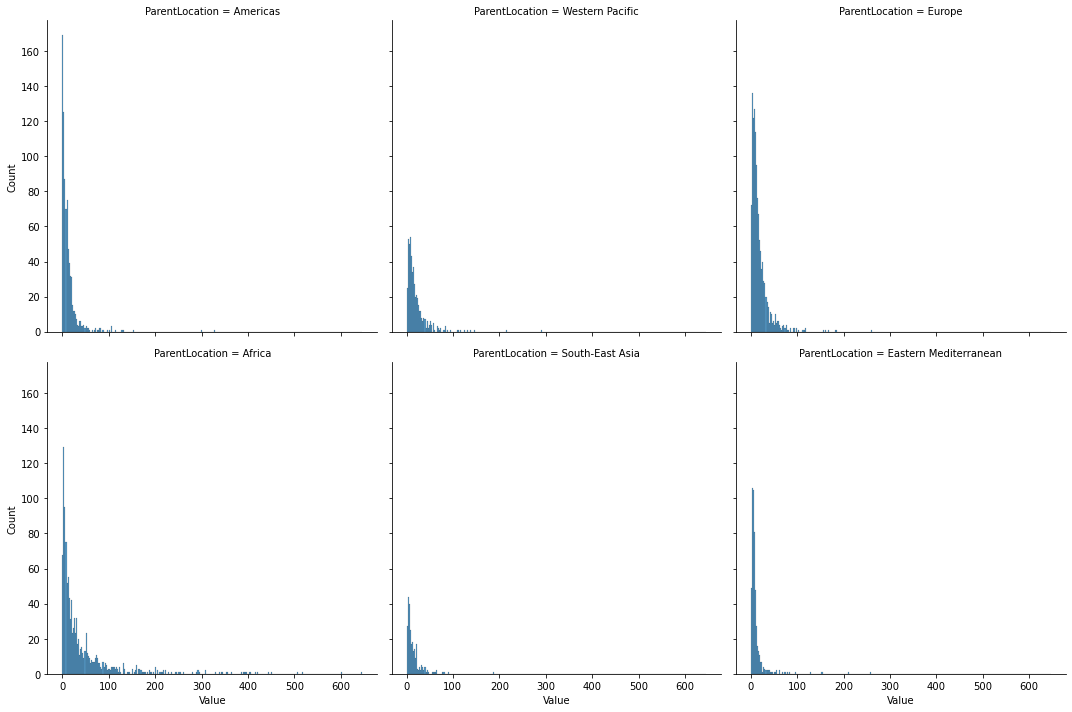

In [113]:
#Figure level plot to aid visualization
sns.displot(data=suicides_clean, x='Value', col='ParentLocation', col_wrap=3)

Spread is still right skewed at the region level <br>
An indepth look at the IQR, median and range is needed

<AxesSubplot:xlabel='Value', ylabel='ParentLocation'>

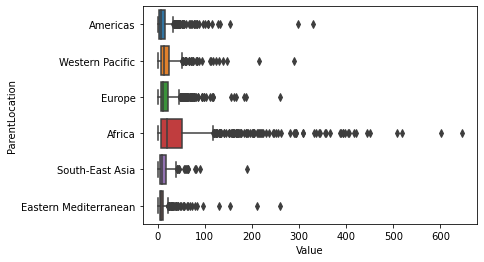

In [114]:
sns.boxplot(data=suicides_clean, x='Value', y='ParentLocation')

Africa appears to have the largest range for suicide rates <br>
The IQR and median is higher than other regions as well

### Are the suicide rates for each region statiscally different?<br>
Null Hypothesis - The suicides rates means do not differ between regions<br>
Alt Hypothesis - Suicide rates are not equal between the regions

#### One way ANOVA Test<br>

##### ANOVA Assumptions<br>
--- Taken from codecademy ---<br>
(1) All observations should be independently and randomly sampled<br>
(2) The standard deviations of the groups should be equal<br>
(3) The data should be normally distributed or the sample size should be large<br>
(4) The groups created by the categorical variable should be independent<br>
-------------------------------- <br>
Signifcance Threshold = 0.05

In [115]:
# Checking for sample sizes between regions. Ideally sample sizes between categories should be close
suicides_clean.ParentLocation.value_counts()

Europe                   1200
Africa                   1128
Americas                  792
Western Pacific           504
Eastern Mediterranean     504
South-East Asia           264
Name: ParentLocation, dtype: int64

In [116]:
#Calculating std of each region to check if assumption 2 is met (std of groups should be equal)
regions = list(suicides_clean.ParentLocation.unique())

for region in regions:
    print(region, suicides_clean[suicides_clean.ParentLocation == region].Value.std())

Americas 22.964103466021808
Western Pacific 25.380683249866067
Europe 20.74263758880902
Africa 73.00099272699414
South-East Asia 18.025657547367828
Eastern Mediterranean 20.032300343547757


#### Zscore Normalization

In [117]:
#Use the zscore of the value column to reduce the effects of outliers on assumptions 2 and 3
zscore_standard_threshold = 3
suicides_zscored = suicides_clean[(np.abs(zscore(suicides_clean.Value)) < zscore_standard_threshold)]
suicides_zscored.ParentLocation.value_counts()

Europe                   1194
Africa                   1053
Americas                  790
Western Pacific           502
Eastern Mediterranean     501
South-East Asia           263
Name: ParentLocation, dtype: int64

In [118]:
#Checking std difference after zscore to meet ANOVA assumption 2
for region in regions:
    print(region, suicides_zscored[suicides_zscored.ParentLocation == region].Value.std())

Americas 17.263127064688007
Western Pacific 20.631981315163138
Europe 16.86252664801223
Africa 31.282724244398867
South-East Asia 14.494568035436131
Eastern Mediterranean 12.649211232041882


<AxesSubplot:xlabel='Value', ylabel='ParentLocation'>

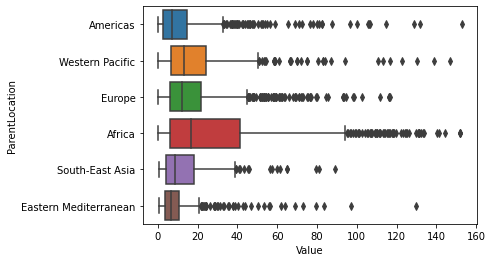

In [119]:
#Visualization of zcored distribution for assumption 3
sns.boxplot(data=suicides_zscored, x='Value', y='ParentLocation')

Zscored boxplot of suicide rates  ----<br> 
It's easier to see Africa has a larger median, IQR and range<br>
The Eastern Mediterranean appears to have the lowest suicide rates

#### Zscore normalization ANOVA Test

In [120]:
#Dividing suicide rates by region to prep for anova test
suicide_regions = {region:suicides_zscored.Value[suicides_zscored.ParentLocation == region] for region in regions}
print(suicide_regions.keys())

dict_keys(['Americas', 'Western Pacific', 'Europe', 'Africa', 'South-East Asia', 'Eastern Mediterranean'])


In [121]:
#Anova test to determine if the pval is significant
fstat, pval = f_oneway(suicide_regions['Americas'], suicide_regions['Europe'], suicide_regions['Africa'],
                       suicide_regions['South-East Asia'], suicide_regions['Eastern Mediterranean'], suicide_regions['Western Pacific'])
print(pval)

1.1739667390651843e-84


In [122]:
#Tukey's Range Test to determine which pairings are significant
sig_threshold = 0.05
tukey_results = pairwise_tukeyhsd(suicides_zscored.Value, suicides_zscored.ParentLocation, sig_threshold)
print(tukey_results)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
               Africa              Americas -16.7287   -0.0 -19.5889 -13.8684   True
               Africa Eastern Mediterranean -18.9917   -0.0 -22.2898 -15.6936   True
               Africa                Europe -11.8437   -0.0 -14.4127  -9.2747   True
               Africa       South-East Asia -15.2708   -0.0 -19.4598 -11.0819   True
               Africa       Western Pacific  -9.6405   -0.0 -12.9364  -6.3447   True
             Americas Eastern Mediterranean  -2.2631 0.4278  -5.7337   1.2075  False
             Americas                Europe   4.8849    0.0    2.098   7.6719   True
             Americas       South-East Asia   1.4578 0.9302  -2.8683   5.7839  False
             Americas       Western Pacific   7.0881    0.0   3.6

##### Africa is significantly different from every other region<br>
Region pairs that are not significantly different are: (pval >= 0.05)<br>
Americas - Eastern Mediterranean<br>
Americas - South-East Asia<br>
Eastern Mediterranean - South-East Asia<br>
Europe - South-East Asia<br>
Europe - Western Pacific<br>


The Zscored Suicide Rates ANOVA test results should be used with caution. Assumption 2 and 3 are not closely followed even after the removal of outliers.<br>
A Natural Log (ln) standarization of suicide rates should be tested for comparison

#### Natural Log Transformation

Useful to transform right skewed data into a more normal distribution<br>
Cannot be used with negative values or zero as the ln of a negative = undefined

In [132]:
# Copy to perform ln transformation to preserve clean dataset
suicides_ln = suicides_clean.copy()

#Remove all suicide rates <=0 to prep for transformation
suicides_ln = suicides_ln[suicides_ln.Value > 0]

# Check number of records removed
records_removed = len(suicides_clean) - len(suicides_ln)
print(f'{records_removed} records removed')

# ln transformation for data profiling and ANOVA test
suicides_ln['Value'] = np.log(suicides_ln['Value'])
suicides_ln.head()

104 records removed


,ParentLocation,Location,Period,Value,Sex,AgeMin,AgeMax
104,Americas,Barbados,2019,-1.049822,Both,35,44
105,Americas,Panama,2019,-0.755023,Female,35,44
106,Europe,Armenia,2019,-0.579818,Female,35,44
107,Americas,Panama,2019,-0.579818,Female,45,54
108,South-East Asia,Maldives,2019,-0.562119,Female,35,44


In [133]:
#Calculating std of each region to check if assumption 2 is met (std of groups should be equal)
for region in regions:
    print(region, suicides_ln[suicides_ln.ParentLocation == region].Value.std())

Americas 1.06146108159323
Western Pacific 0.9396810223680948
Europe 0.9617429300782172
Africa 1.365173016942006
South-East Asia 1.0310594118310943
Eastern Mediterranean 0.9159559447494597


<AxesSubplot:xlabel='Value', ylabel='ParentLocation'>

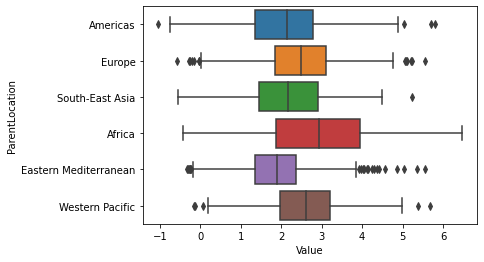

In [134]:
#Visualization of ln transformation distribution for assumption 3
sns.boxplot(data=suicides_ln, x='Value', y='ParentLocation')

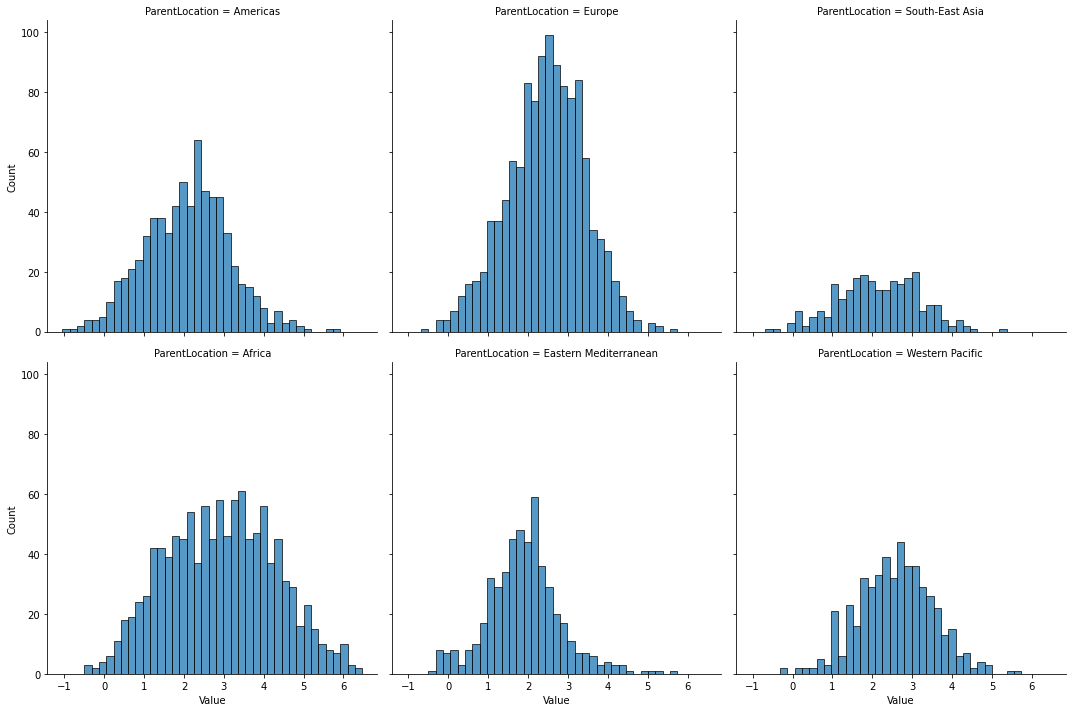

In [135]:
sns.displot(data=suicides_ln, x='Value', col='ParentLocation', col_wrap=3)

Distribution for each region normalized compared to clean dataset<br>
Suicide Rates = e^Value

#### Natural log transformation ANOVA Test

In [136]:
#Dividing suicide rates by region to prep for anova test
suicide_regions2 = {region:suicides_ln.Value[suicides_ln.ParentLocation == region] for region in regions}
print(suicide_regions2.keys())

dict_keys(['Americas', 'Western Pacific', 'Europe', 'Africa', 'South-East Asia', 'Eastern Mediterranean'])


In [137]:
#Anova test to determine if the pval is significant
fstat, pval = f_oneway(suicide_regions2['Americas'], suicide_regions2['Europe'], suicide_regions2['Africa'],
                       suicide_regions2['South-East Asia'], suicide_regions2['Eastern Mediterranean'], suicide_regions2['Western Pacific'])
print(pval)

2.206517528948446e-89


In [139]:
#Tukey's Range Test to determine which pairings are significant
sig_threshold = 0.05
tukey_results_ln = pairwise_tukeyhsd(suicides_ln.Value, suicides_ln.ParentLocation, sig_threshold)
print(tukey_results)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
               Africa              Americas -16.7287   -0.0 -19.5889 -13.8684   True
               Africa Eastern Mediterranean -18.9917   -0.0 -22.2898 -15.6936   True
               Africa                Europe -11.8437   -0.0 -14.4127  -9.2747   True
               Africa       South-East Asia -15.2708   -0.0 -19.4598 -11.0819   True
               Africa       Western Pacific  -9.6405   -0.0 -12.9364  -6.3447   True
             Americas Eastern Mediterranean  -2.2631 0.4278  -5.7337   1.2075  False
             Americas                Europe   4.8849    0.0    2.098   7.6719   True
             Americas       South-East Asia   1.4578 0.9302  -2.8683   5.7839  False
             Americas       Western Pacific   7.0881    0.0   3.6

##### Africa is significantly different from every other region<br>
Region pairs that are not significantly different are: (pval >= 0.05)<br>
Americas - Eastern Mediterranean<br>
Americas - South-East Asia<br>
Eastern Mediterranean - South-East Asia<br>
Europe - South-East Asia<br>
Europe - Western Pacific<br>
Natural Log transformation ANOVA test supports the results from the zscored normalized ANOVA test